# OLED Optimization with FourierFields


In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Al as ALU

mp.verbosity(0)

GLS = mp.Medium(index=1.5)    # 글래스의 굴절률 설정
ITO = mp.Medium(index=1.2)    # ITO의 굴절률 설정
ORG = mp.Medium(index=1.75)   # OLED 유기층의 굴절률 설정
SiN = mp.Medium(index=1.9)    # 실리콘 질화물의 굴절률 설정

Basic setup

In [2]:
lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.8       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 25             # 추출할 주파수 개수
design_region_resolution = 50                                                             

tABS = 0.5    # X/Y 방향 흡수 경계층 두께
tPML = 0.5    # Z 방향 PML 경계층 두께
tGLS = 0.5    # 글래스 층 두께
tITO = 0.5    # ITO 층 두께
tORG = 0.5    # 유기층(OLED 발광층) 두께
tALU = 0.2    # 알루미늄(캐소드) 두께

L = 1.0       # OLED의 가로/세로 길이

design_region_width = L
design_region_height = 0.2

Sy = tPML + tGLS + design_region_height + tITO + tORG + tALU  # Z 방향 전체 길이
Sx = L + 2*tABS                        # X/Y 방향 길이
cell_size = mp.Vector3(Sx, Sy)    # 시뮬레이션 셀 크기

boundary_layers = [mp.Absorber(tABS,direction=mp.X),
                   mp.PML(tPML,direction=mp.Y,side=mp.High)]

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), GLS, SiN, grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(y=0.5*Sy - tPML - tGLS - 0.5*design_region_height),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

geometry = [
    mp.Block(material=GLS,      # 유리층
             size=mp.Vector3(mp.inf, tPML + tGLS),
             center=mp.Vector3(y=0.5*Sy - 0.5*(tPML + tGLS))),

    mp.Block(material=design_variables,      # 디자인 영역
             size=design_region.size,
             center=design_region.center),
    
    mp.Block(material=ITO,      # ITO 층
             size=mp.Vector3(mp.inf, tITO),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - 0.5*tITO)),
    
    mp.Block(material=ORG,                       # 유기층
             size=mp.Vector3(mp.inf, tORG),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG)),
    
    mp.Block(material=ALU,                       # 알루미늄 층
             size=mp.Vector3(mp.inf, tALU),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - tORG - 0.5*tALU))
]

src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = []
src_num = 7

for i in range(src_num):  # x 방향 루프
        sources.append(
            mp.Source(
                src,
                component=mp.Ez,
                center=mp.Vector3(
                    x = -design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),  
                    y = 0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG,
                    z = 0
                )
            )
        )

sim = []

for i in range(src_num):
    sim.append(
        mp.Simulation(resolution=resolution,
                      cell_size=cell_size,
                      boundary_layers=boundary_layers,
                      geometry=geometry,
                      sources=[sources[i]],
                      extra_materials=[ALU],)
    )

                    

<Axes: xlabel='X', ylabel='Y'>

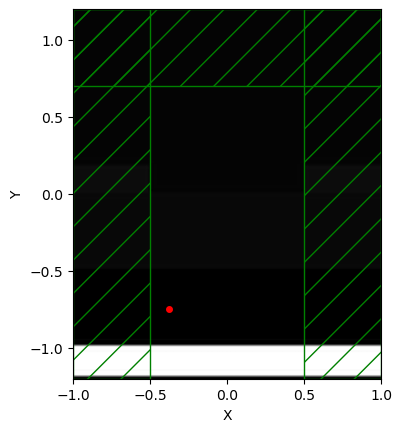

In [3]:
sim[0].plot2D()

In [4]:
monitor_position, monitor_size = mp.Vector3(0,0.5*Sy-tPML-(tGLS-0.05)), mp.Vector3(L,0)

FourierFields_Ez = []
FourierFields_Hx = []
for i in range(src_num):
    FourierFields_Ez.append(mpa.FourierFields(sim[i],mp.Volume(center=monitor_position,size=monitor_size),mp.Ez,yee_grid=True))
    FourierFields_Hx.append(mpa.FourierFields(sim[i],mp.Volume(center=monitor_position,size=monitor_size),mp.Hx,yee_grid=True))
ob_list_Ez = []
ob_list_Hx = []
for i in range(src_num):
    ob_list_Ez.append(FourierFields_Ez[i])
    ob_list_Hx.append(FourierFields_Hx[i])

def J(fields_Ez, fields_Hx):
    return -npa.real(npa.sum(fields_Ez[:,:]*(npa.real(fields_Hx[:,:])-npa.imag(fields_Hx[:,:])*1j)))

opt = []
for i in range(src_num):
    opt.append(mpa.OptimizationProblem(
        simulation=sim[i],
        objective_functions=[J],
        objective_arguments=[ob_list_Ez[i], ob_list_Hx[i]],
        design_regions=[design_region],
        frequencies=[fcen],
        maximum_run_time=100,
    ))

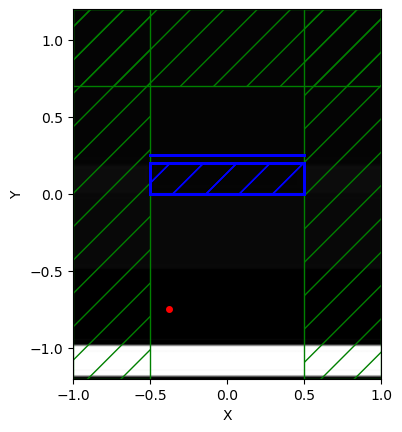

In [5]:
opt[0].plot2D(True)

In [6]:
minimum_length = 0.02  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

In [7]:
def mapping(x, eta, beta):

    # # filter
    # filtered_field = mpa.conic_filter(
    #     x,
    #     filter_radius,
    #     design_region_width,
    #     design_region_height,
    #     design_region_resolution,
    # )

    # # projection
    # projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    # interpolate to actual materials
    return x

In [8]:
evaluation_history = []
cur_iter = [0]
numevl = 1

def f(x, gradient):
    t = x[0]
    v = x[1:]
    if gradient.size > 0:
        gradient[0] = 1
        gradient[1:] = 0
    return t

def c(result, x, gradient, beta):

    print("Current iteration: {}".format(cur_iter[0] + 1))

    global numevl
    t=x[0]
    v=x[1:]
    f0 = []
    dJ_du = []

    for i in range(src_num):
        f0_i, dJ_du_i = opt[i]([mapping(v, eta_i, beta)])
        f0.append(f0_i.flatten())
        dJ_du.append(dJ_du_i)

    my_grad = np.zeros((Nx * Ny, src_num))

    for i in range(src_num):
        my_grad[:,i] = dJ_du[i]

    for k in range(src_num):
        my_grad[:,k] = tensor_jacobian_product(mapping,0)(
            v,
            eta_i,
            cur_beta,
            my_grad[:,k],
        )


    if gradient.size > 0:
        gradient[:, 0] = -1
        gradient[:, 1:] = my_grad.T

    result[:] = (np.real(f0) - t).reshape(-1)

    evaluation_history.append([np.max(np.real(f0[i])) for i in range(src_num)])

    numevl += 1
    cur_iter[0] = cur_iter[0] + 1

    print("First FoM: {}".format(evaluation_history[0]))
    print("Current f0 values: " + ", ".join(["f0_{}: {}".format(i, np.real(f0[i])) for i in range(src_num)]))


In [9]:
algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
ub = np.ones((Nx * Ny,))

# insert dummy parameter bounds and variable
x = np.insert(x, 0, -1)  # our initial guess for the worst error
lb = np.insert(lb, 0, -np.inf) # lower bound for the error
ub = np.insert(ub, 0, 0) # upper bound for the error

# Optimization parameter
cur_beta = 4 # initial beta value
beta_scale = 1.5 # scaling factor for beta updates
num_betas = 9 # number of beta updates
tol_epi = np.array([1e-4] * src_num) # tolerances for the epsilon constraints
update_factor = 12  # number of iterations between beta updates
ftol = 1e-5  # tolerance for the objective function

# Optimization
for iters in range(num_betas):
    print("current beta: ", cur_beta)
    solver = nlopt.opt(algorithm, n+1)
    solver.set_lower_bounds(lb) # lower bounds
    solver.set_upper_bounds(ub) # upper bounds
    solver.set_min_objective(f)
    solver.add_inequality_mconstraint(
        lambda rr, xx, gg: c(
            rr,
            xx,
            gg,
            cur_beta,
        ),
        tol_epi
    )
    solver.set_maxeval(update_factor) # Set the maximum number of function evaluations
        
    # solver.set_param("dual_ftol_rel", 1e-7)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta * beta_scale # Update the beta value for the next iteration


current beta:  4
Current iteration: 1
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-6.88268385], f0_1: [-6.19611854], f0_2: [-6.33916643], f0_3: [-6.17662814], f0_4: [-6.33916643], f0_5: [-6.19611854], f0_6: [-6.88268385]
Current iteration: 2
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-6.88268385], f0_1: [-6.19611854], f0_2: [-6.33916643], f0_3: [-6.17662814], f0_4: [-6.33916643], f0_5: [-6.19611854], f0_6: [-6.88268385]
Current iteration: 3
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-6.88268385], f0_1: [-6.19611854], f0_2: [-6.33916643], f0_3: [-6.17662814], f0_4: [-6.33916643], f0_5: [-6.19611854], f0_6: [-6.88268385]
Current iteration: 4
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-6.88752798], f0_1: [-6.20190679], f0_2: [-6.35666643], f0_3: [-6.20204198], f0_4: [-6.35666643], f0_5: [-6.20190679], f0_6: [-6.88752798]
Current iteration: 5
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-7.0057673], f0_1: [-6.41535866], f0_2: [-6.59789771], f0_3: [-6.42400182], f0_4: [-6.59789771], f0_5: [-6.41535866], f0_6: [-7.0057673]
Current iteration: 6
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-7.44399465], f0_1: [-7.37242928], f0_2: [-7.71806353], f0_3: [-7.49292765], f0_4: [-7.71806353], f0_5: [-7.37242928], f0_6: [-7.44399465]
Current iteration: 7
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-7.79675944], f0_1: [-7.83483756], f0_2: [-8.12488838], f0_3: [-7.85788275], f0_4: [-8.12488838], f0_5: [-7.83483756], f0_6: [-7.79675944]
Current iteration: 8
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-7.89732566], f0_1: [-7.91424166], f0_2: [-8.17097], f0_3: [-7.8992221], f0_4: [-8.17097], f0_5: [-7.91424166], f0_6: [-7.89732566]
Current iteration: 9
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-7.93910981], f0_1: [-7.94249523], f0_2: [-8.20212288], f0_3: [-7.94424536], f0_4: [-8.20212288], f0_5: [-7.94249523], f0_6: [-7.93910981]
Current iteration: 10
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-7.97783686], f0_1: [-7.97961565], f0_2: [-8.23702196], f0_3: [-7.98285495], f0_4: [-8.23702196], f0_5: [-7.97961565], f0_6: [-7.97783686]
Current iteration: 11
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.00785148], f0_1: [-8.00738078], f0_2: [-8.26336888], f0_3: [-8.01200195], f0_4: [-8.26336888], f0_5: [-8.00738078], f0_6: [-8.00785148]
Current iteration: 12
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.02836354], f0_1: [-8.0272601], f0_2: [-8.28032858], f0_3: [-8.03102071], f0_4: [-8.28032858], f0_5: [-8.0272601], f0_6: [-8.02836354]
current beta:  6.0
Current iteration: 13
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.02836354], f0_1: [-8.0272601], f0_2: [-8.28032858], f0_3: [-8.03102071], f0_4: [-8.28032858], f0_5: [-8.0272601], f0_6: [-8.02836354]
Current iteration: 14
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.02891109], f0_1: [-8.02891369], f0_2: [-8.28015073], f0_3: [-8.02891592], f0_4: [-8.28015073], f0_5: [-8.02891369], f0_6: [-8.02891109]
Current iteration: 15
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.02956292], f0_1: [-8.02956126], f0_2: [-8.28072765], f0_3: [-8.02957217], f0_4: [-8.28072765], f0_5: [-8.02956126], f0_6: [-8.02956292]
Current iteration: 16
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.033545], f0_1: [-8.03346179], f0_2: [-8.28427439], f0_3: [-8.03390299], f0_4: [-8.28427439], f0_5: [-8.03346179], f0_6: [-8.033545]
Current iteration: 17
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.04121327], f0_1: [-8.04169106], f0_2: [-8.29174235], f0_3: [-8.04237088], f0_4: [-8.29174235], f0_5: [-8.04169106], f0_6: [-8.04121327]
Current iteration: 18
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.04993021], f0_1: [-8.05009662], f0_2: [-8.29951061], f0_3: [-8.05100041], f0_4: [-8.29951061], f0_5: [-8.05009662], f0_6: [-8.04993021]
Current iteration: 19
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.05670905], f0_1: [-8.05676464], f0_2: [-8.305386], f0_3: [-8.05754375], f0_4: [-8.305386], f0_5: [-8.05676464], f0_6: [-8.05670905]
Current iteration: 20
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.06165967], f0_1: [-8.06153687], f0_2: [-8.30955551], f0_3: [-8.06289201], f0_4: [-8.30955551], f0_5: [-8.06153687], f0_6: [-8.06165967]
Current iteration: 21
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.06629548], f0_1: [-8.06614951], f0_2: [-8.31307273], f0_3: [-8.06745641], f0_4: [-8.31307273], f0_5: [-8.06614951], f0_6: [-8.06629548]
Current iteration: 22
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.07023108], f0_1: [-8.07016621], f0_2: [-8.3157132], f0_3: [-8.07093093], f0_4: [-8.3157132], f0_5: [-8.07016621], f0_6: [-8.07023108]
Current iteration: 23
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.07248246], f0_1: [-8.07241711], f0_2: [-8.31733546], f0_3: [-8.07291056], f0_4: [-8.31733546], f0_5: [-8.07241711], f0_6: [-8.07248246]
Current iteration: 24
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.07414692], f0_1: [-8.07413976], f0_2: [-8.31884295], f0_3: [-8.0746497], f0_4: [-8.31884295], f0_5: [-8.07413976], f0_6: [-8.07414692]
current beta:  9.0
Current iteration: 25
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.07414692], f0_1: [-8.07413976], f0_2: [-8.31884295], f0_3: [-8.0746497], f0_4: [-8.31884295], f0_5: [-8.07413976], f0_6: [-8.07414692]
Current iteration: 26
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.07429261], f0_1: [-8.07429293], f0_2: [-8.31870887], f0_3: [-8.07429286], f0_4: [-8.31870887], f0_5: [-8.07429293], f0_6: [-8.07429261]
Current iteration: 27
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.07432887], f0_1: [-8.07432886], f0_2: [-8.31873718], f0_3: [-8.07433001], f0_4: [-8.31873718], f0_5: [-8.07432886], f0_6: [-8.07432887]
Current iteration: 28
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.07449915], f0_1: [-8.07450552], f0_2: [-8.31889717], f0_3: [-8.07452598], f0_4: [-8.31889717], f0_5: [-8.07450552], f0_6: [-8.07449915]
Current iteration: 29
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.07492963], f0_1: [-8.07496754], f0_2: [-8.31934655], f0_3: [-8.07507668], f0_4: [-8.31934655], f0_5: [-8.07496754], f0_6: [-8.07492963]
Current iteration: 30
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.0755232], f0_1: [-8.07555881], f0_2: [-8.31988071], f0_3: [-8.07571796], f0_4: [-8.31988071], f0_5: [-8.07555881], f0_6: [-8.0755232]
Current iteration: 31
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.07612085], f0_1: [-8.07612557], f0_2: [-8.32039469], f0_3: [-8.07628941], f0_4: [-8.32039469], f0_5: [-8.07612557], f0_6: [-8.07612085]
Current iteration: 32
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.07676421], f0_1: [-8.07677076], f0_2: [-8.3209909], f0_3: [-8.07696427], f0_4: [-8.3209909], f0_5: [-8.07677076], f0_6: [-8.07676421]
Current iteration: 33
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.07742733], f0_1: [-8.07745169], f0_2: [-8.32163645], f0_3: [-8.07768737], f0_4: [-8.32163645], f0_5: [-8.07745169], f0_6: [-8.07742733]
Current iteration: 34
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.07818207], f0_1: [-8.07820826], f0_2: [-8.32234239], f0_3: [-8.07849484], f0_4: [-8.32234239], f0_5: [-8.07820826], f0_6: [-8.07818207]
Current iteration: 35
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.07900692], f0_1: [-8.07905042], f0_2: [-8.32315157], f0_3: [-8.0793478], f0_4: [-8.32315157], f0_5: [-8.07905042], f0_6: [-8.07900692]
Current iteration: 36
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.0797767], f0_1: [-8.07982326], f0_2: [-8.32389743], f0_3: [-8.08009369], f0_4: [-8.32389743], f0_5: [-8.07982326], f0_6: [-8.0797767]
current beta:  13.5
Current iteration: 37
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.0797767], f0_1: [-8.07982326], f0_2: [-8.32389743], f0_3: [-8.08009369], f0_4: [-8.32389743], f0_5: [-8.07982326], f0_6: [-8.0797767]
Current iteration: 38
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.07988389], f0_1: [-8.07988428], f0_2: [-8.32379125], f0_3: [-8.07988397], f0_4: [-8.32379125], f0_5: [-8.07988428], f0_6: [-8.07988389]
Current iteration: 39
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.07989916], f0_1: [-8.07989959], f0_2: [-8.32380218], f0_3: [-8.07989992], f0_4: [-8.32380218], f0_5: [-8.07989959], f0_6: [-8.07989916]
Current iteration: 40
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.07996456], f0_1: [-8.07996684], f0_2: [-8.32386662], f0_3: [-8.07997798], f0_4: [-8.32386662], f0_5: [-8.07996684], f0_6: [-8.07996456]
Current iteration: 41
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.0801268], f0_1: [-8.08013889], f0_2: [-8.32404285], f0_3: [-8.08019763], f0_4: [-8.32404285], f0_5: [-8.08013889], f0_6: [-8.0801268]
Current iteration: 42
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08034953], f0_1: [-8.08036463], f0_2: [-8.32425641], f0_3: [-8.08044428], f0_4: [-8.32425641], f0_5: [-8.08036463], f0_6: [-8.08034953]
Current iteration: 43
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08058925], f0_1: [-8.08059952], f0_2: [-8.32445345], f0_3: [-8.08069375], f0_4: [-8.32445345], f0_5: [-8.08059952], f0_6: [-8.08058925]
Current iteration: 44
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08086117], f0_1: [-8.08085963], f0_2: [-8.32466806], f0_3: [-8.08096679], f0_4: [-8.32466806], f0_5: [-8.08085963], f0_6: [-8.08086117]
Current iteration: 45
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08112016], f0_1: [-8.08109779], f0_2: [-8.3248584], f0_3: [-8.08121814], f0_4: [-8.3248584], f0_5: [-8.08109779], f0_6: [-8.08112016]
Current iteration: 46
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.081364], f0_1: [-8.08134441], f0_2: [-8.32504601], f0_3: [-8.08143674], f0_4: [-8.32504601], f0_5: [-8.08134441], f0_6: [-8.081364]
Current iteration: 47
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08151364], f0_1: [-8.08149643], f0_2: [-8.32514285], f0_3: [-8.08156019], f0_4: [-8.32514285], f0_5: [-8.08149643], f0_6: [-8.08151364]
Current iteration: 48
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.0816793], f0_1: [-8.08165774], f0_2: [-8.32525768], f0_3: [-8.08173484], f0_4: [-8.32525768], f0_5: [-8.08165774], f0_6: [-8.0816793]
current beta:  20.25
Current iteration: 49
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.0816793], f0_1: [-8.08165774], f0_2: [-8.32525768], f0_3: [-8.08173484], f0_4: [-8.32525768], f0_5: [-8.08165774], f0_6: [-8.0816793]
Current iteration: 50
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08168805], f0_1: [-8.08168781], f0_2: [-8.32525019], f0_3: [-8.08168786], f0_4: [-8.32525019], f0_5: [-8.08168781], f0_6: [-8.08168805]
Current iteration: 51
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08169162], f0_1: [-8.08169182], f0_2: [-8.32525267], f0_3: [-8.08169168], f0_4: [-8.32525267], f0_5: [-8.08169182], f0_6: [-8.08169162]
Current iteration: 52
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08171491], f0_1: [-8.08171281], f0_2: [-8.32526691], f0_3: [-8.08171938], f0_4: [-8.32526691], f0_5: [-8.08171281], f0_6: [-8.08171491]
Current iteration: 53
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08176557], f0_1: [-8.08175738], f0_2: [-8.32529831], f0_3: [-8.08178286], f0_4: [-8.32529831], f0_5: [-8.08175738], f0_6: [-8.08176557]
Current iteration: 54
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08183199], f0_1: [-8.08182087], f0_2: [-8.3253369], f0_3: [-8.0818559], f0_4: [-8.3253369], f0_5: [-8.08182087], f0_6: [-8.08183199]
Current iteration: 55
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08191213], f0_1: [-8.08189879], f0_2: [-8.32538248], f0_3: [-8.081941], f0_4: [-8.32538248], f0_5: [-8.08189879], f0_6: [-8.08191213]
Current iteration: 56
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.0820078], f0_1: [-8.08199133], f0_2: [-8.32543576], f0_3: [-8.08204232], f0_4: [-8.32543576], f0_5: [-8.08199133], f0_6: [-8.0820078]
Current iteration: 57
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08212155], f0_1: [-8.08210165], f0_2: [-8.3254983], f0_3: [-8.08216265], f0_4: [-8.3254983], f0_5: [-8.08210165], f0_6: [-8.08212155]
Current iteration: 58
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.0822381], f0_1: [-8.08222021], f0_2: [-8.32556194], f0_3: [-8.08227551], f0_4: [-8.32556194], f0_5: [-8.08222021], f0_6: [-8.0822381]
Current iteration: 59
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08234595], f0_1: [-8.0823278], f0_2: [-8.32561547], f0_3: [-8.08237976], f0_4: [-8.32561547], f0_5: [-8.0823278], f0_6: [-8.08234595]
Current iteration: 60
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08244774], f0_1: [-8.08243216], f0_2: [-8.32564478], f0_3: [-8.08247815], f0_4: [-8.32564478], f0_5: [-8.08243216], f0_6: [-8.08244774]
current beta:  30.375
Current iteration: 61
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08244774], f0_1: [-8.08243216], f0_2: [-8.32564478], f0_3: [-8.08247815], f0_4: [-8.32564478], f0_5: [-8.08243216], f0_6: [-8.08244774]


Current iteration: 62
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08245134], f0_1: [-8.082451], f0_2: [-8.32564208], f0_3: [-8.08245116], f0_4: [-8.32564208], f0_5: [-8.082451], f0_6: [-8.08245134]
Current iteration: 63
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08245226], f0_1: [-8.08245253], f0_2: [-8.32564231], f0_3: [-8.08245263], f0_4: [-8.32564231], f0_5: [-8.08245253], f0_6: [-8.08245226]
Current iteration: 64
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08245861], f0_1: [-8.08245904], f0_2: [-8.3256406], f0_3: [-8.08246], f0_4: [-8.3256406], f0_5: [-8.08245904], f0_6: [-8.08245861]
Current iteration: 65
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08247386], f0_1: [-8.0824743], f0_2: [-8.32563758], f0_3: [-8.08247899], f0_4: [-8.32563758], f0_5: [-8.0824743], f0_6: [-8.08247386]
Current iteration: 66
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08249448], f0_1: [-8.08249508], f0_2: [-8.32563318], f0_3: [-8.08250155], f0_4: [-8.32563318], f0_5: [-8.08249508], f0_6: [-8.08249448]
Current iteration: 67
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08251895], f0_1: [-8.08251978], f0_2: [-8.32562773], f0_3: [-8.08252773], f0_4: [-8.32562773], f0_5: [-8.08251978], f0_6: [-8.08251895]
Current iteration: 68
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08254778], f0_1: [-8.08254848], f0_2: [-8.32562075], f0_3: [-8.08255777], f0_4: [-8.32562075], f0_5: [-8.08254848], f0_6: [-8.08254778]
Current iteration: 69
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08256837], f0_1: [-8.08256967], f0_2: [-8.32561318], f0_3: [-8.08257367], f0_4: [-8.32561318], f0_5: [-8.08256967], f0_6: [-8.08256837]
Current iteration: 70
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.0825892], f0_1: [-8.08259077], f0_2: [-8.32560526], f0_3: [-8.08259531], f0_4: [-8.32560526], f0_5: [-8.08259077], f0_6: [-8.0825892]
Current iteration: 71
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08260893], f0_1: [-8.08261106], f0_2: [-8.32560066], f0_3: [-8.08261694], f0_4: [-8.32560066], f0_5: [-8.08261106], f0_6: [-8.08260893]
Current iteration: 72
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08262673], f0_1: [-8.08262966], f0_2: [-8.32560524], f0_3: [-8.08263408], f0_4: [-8.32560524], f0_5: [-8.08262966], f0_6: [-8.08262673]
current beta:  45.5625
Current iteration: 73
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08262673], f0_1: [-8.08262966], f0_2: [-8.32560524], f0_3: [-8.08263408], f0_4: [-8.32560524], f0_5: [-8.08262966], f0_6: [-8.08262673]
Current iteration: 74
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08262818], f0_1: [-8.08263087], f0_2: [-8.32560384], f0_3: [-8.08263079], f0_4: [-8.32560384], f0_5: [-8.08263087], f0_6: [-8.08262818]
Current iteration: 75
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08263032], f0_1: [-8.08262986], f0_2: [-8.3256019], f0_3: [-8.08262987], f0_4: [-8.3256019], f0_5: [-8.08262986], f0_6: [-8.08263032]
Current iteration: 76
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08263132], f0_1: [-8.08263146], f0_2: [-8.32560382], f0_3: [-8.0826315], f0_4: [-8.32560382], f0_5: [-8.08263146], f0_6: [-8.08263132]
Current iteration: 77
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08263484], f0_1: [-8.08263557], f0_2: [-8.32560942], f0_3: [-8.08263638], f0_4: [-8.32560942], f0_5: [-8.08263557], f0_6: [-8.08263484]
Current iteration: 78
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08264003], f0_1: [-8.08264126], f0_2: [-8.32561644], f0_3: [-8.08264211], f0_4: [-8.32561644], f0_5: [-8.08264126], f0_6: [-8.08264003]
Current iteration: 79
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08264641], f0_1: [-8.08264803], f0_2: [-8.3256244], f0_3: [-8.08264893], f0_4: [-8.3256244], f0_5: [-8.08264803], f0_6: [-8.08264641]
Current iteration: 80
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08265418], f0_1: [-8.08265577], f0_2: [-8.32563321], f0_3: [-8.08265716], f0_4: [-8.32563321], f0_5: [-8.08265577], f0_6: [-8.08265418]
Current iteration: 81
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08266313], f0_1: [-8.08266539], f0_2: [-8.32564339], f0_3: [-8.08266682], f0_4: [-8.32564339], f0_5: [-8.08266539], f0_6: [-8.08266313]
Current iteration: 82
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08267386], f0_1: [-8.08267661], f0_2: [-8.3256546], f0_3: [-8.08267834], f0_4: [-8.3256546], f0_5: [-8.08267661], f0_6: [-8.08267386]
Current iteration: 83
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08268664], f0_1: [-8.08268978], f0_2: [-8.3256669], f0_3: [-8.08269206], f0_4: [-8.3256669], f0_5: [-8.08268978], f0_6: [-8.08268664]
Current iteration: 84
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08270171], f0_1: [-8.08270546], f0_2: [-8.32568046], f0_3: [-8.08270823], f0_4: [-8.32568046], f0_5: [-8.08270546], f0_6: [-8.08270171]
current beta:  68.34375
Current iteration: 85
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08270171], f0_1: [-8.08270546], f0_2: [-8.32568046], f0_3: [-8.08270823], f0_4: [-8.32568046], f0_5: [-8.08270546], f0_6: [-8.08270171]
Current iteration: 86
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08270343], f0_1: [-8.08270588], f0_2: [-8.32567873], f0_3: [-8.08270552], f0_4: [-8.32567873], f0_5: [-8.08270588], f0_6: [-8.08270343]
Current iteration: 87
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08270518], f0_1: [-8.08270494], f0_2: [-8.32567711], f0_3: [-8.08270495], f0_4: [-8.32567711], f0_5: [-8.08270494], f0_6: [-8.08270518]
Current iteration: 88
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.0827063], f0_1: [-8.08270631], f0_2: [-8.32567812], f0_3: [-8.08270642], f0_4: [-8.32567812], f0_5: [-8.08270631], f0_6: [-8.0827063]
Current iteration: 89
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08270941], f0_1: [-8.08271032], f0_2: [-8.32568206], f0_3: [-8.0827109], f0_4: [-8.32568206], f0_5: [-8.08271032], f0_6: [-8.08270941]
Current iteration: 90
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.0827142], f0_1: [-8.08271547], f0_2: [-8.32568618], f0_3: [-8.08271626], f0_4: [-8.32568618], f0_5: [-8.08271547], f0_6: [-8.0827142]
Current iteration: 91
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08272005], f0_1: [-8.08272159], f0_2: [-8.325691], f0_3: [-8.08272275], f0_4: [-8.325691], f0_5: [-8.08272159], f0_6: [-8.08272005]
Current iteration: 92
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08272682], f0_1: [-8.0827285], f0_2: [-8.32569691], f0_3: [-8.08272938], f0_4: [-8.32569691], f0_5: [-8.0827285], f0_6: [-8.08272682]
Current iteration: 93
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08273369], f0_1: [-8.08273575], f0_2: [-8.32570613], f0_3: [-8.08273656], f0_4: [-8.32570613], f0_5: [-8.08273575], f0_6: [-8.08273369]
Current iteration: 94
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08274186], f0_1: [-8.08274404], f0_2: [-8.32571607], f0_3: [-8.08274536], f0_4: [-8.32571607], f0_5: [-8.08274404], f0_6: [-8.08274186]
Current iteration: 95
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08275143], f0_1: [-8.08275413], f0_2: [-8.32572597], f0_3: [-8.08275552], f0_4: [-8.32572597], f0_5: [-8.08275413], f0_6: [-8.08275143]
Current iteration: 96
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08276294], f0_1: [-8.08276565], f0_2: [-8.32573505], f0_3: [-8.0827677], f0_4: [-8.32573505], f0_5: [-8.08276565], f0_6: [-8.08276294]
current beta:  102.515625
Current iteration: 97
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08276294], f0_1: [-8.08276565], f0_2: [-8.32573505], f0_3: [-8.0827677], f0_4: [-8.32573505], f0_5: [-8.08276565], f0_6: [-8.08276294]
Current iteration: 98
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08276546], f0_1: [-8.08276508], f0_2: [-8.32573242], f0_3: [-8.08276506], f0_4: [-8.32573242], f0_5: [-8.08276508], f0_6: [-8.08276546]
Current iteration: 99
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08276549], f0_1: [-8.08276528], f0_2: [-8.32573249], f0_3: [-8.08276527], f0_4: [-8.32573249], f0_5: [-8.08276528], f0_6: [-8.08276549]
Current iteration: 100
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08276622], f0_1: [-8.0827661], f0_2: [-8.32573194], f0_3: [-8.08276619], f0_4: [-8.32573194], f0_5: [-8.0827661], f0_6: [-8.08276622]
Current iteration: 101
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08276758], f0_1: [-8.0827688], f0_2: [-8.32573082], f0_3: [-8.08276926], f0_4: [-8.32573082], f0_5: [-8.0827688], f0_6: [-8.08276758]
Current iteration: 102
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08277063], f0_1: [-8.0827714], f0_2: [-8.32572591], f0_3: [-8.08277157], f0_4: [-8.32572591], f0_5: [-8.0827714], f0_6: [-8.08277063]
Current iteration: 103
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08277316], f0_1: [-8.08277416], f0_2: [-8.3257194], f0_3: [-8.08277443], f0_4: [-8.3257194], f0_5: [-8.08277416], f0_6: [-8.08277316]
Current iteration: 104
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08277654], f0_1: [-8.08277724], f0_2: [-8.32571105], f0_3: [-8.0827777], f0_4: [-8.32571105], f0_5: [-8.08277724], f0_6: [-8.08277654]
Current iteration: 105
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08278028], f0_1: [-8.08278118], f0_2: [-8.32570117], f0_3: [-8.0827818], f0_4: [-8.32570117], f0_5: [-8.08278118], f0_6: [-8.08278028]
Current iteration: 106
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08278488], f0_1: [-8.08278618], f0_2: [-8.32568893], f0_3: [-8.08278633], f0_4: [-8.32568893], f0_5: [-8.08278618], f0_6: [-8.08278488]
Current iteration: 107
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08279029], f0_1: [-8.08279163], f0_2: [-8.32567395], f0_3: [-8.08279267], f0_4: [-8.32567395], f0_5: [-8.08279163], f0_6: [-8.08279029]
Current iteration: 108
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
First FoM: [-6.882683854828727, -6.196118544531531, -6.339166428944023, -6.176628141144223, -6.339166428944023, -6.196118544531531, -6.882683854828728]
Current f0 values: f0_0: [-8.08279423], f0_1: [-8.08279427], f0_2: [-8.32566033], f0_3: [-8.08279432], f0_4: [-8.32566033], f0_5: [-8.08279427], f0_6: [-8.08279423]


In [10]:
np.savetxt("lastdesign.txt", design_variables.weights)

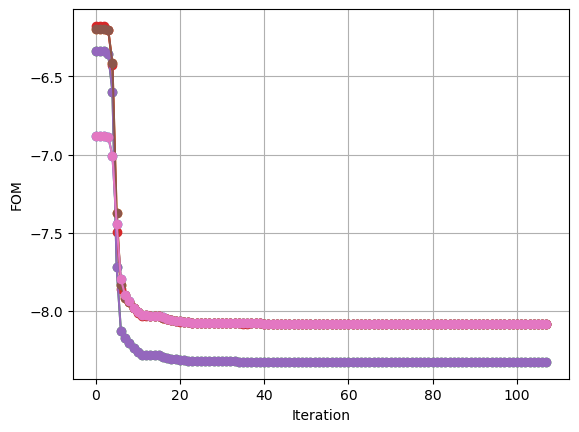

In [11]:
plt.figure()

plt.plot(evaluation_history, "o-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("FOM")
plt.show()

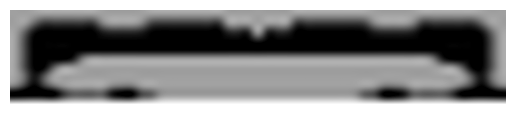

In [12]:
# opt[0].update_design([mapping(x, eta_i, cur_beta/beta_scale)]) # cur_beta/beta_scale is the final beta in the optimization.
plt.figure()
ax = plt.gca()
opt[0].plot2D(
    False,
    output_plane = mp.Volume(size = design_region.size, center = design_region.center),
    ax=ax,
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)
circ = Circle((2, 2), minimum_length / 2)
ax.add_patch(circ)
ax.axis("off")
plt.show()

FloatProgress(value=0.0, description='0% done ', max=200.0)

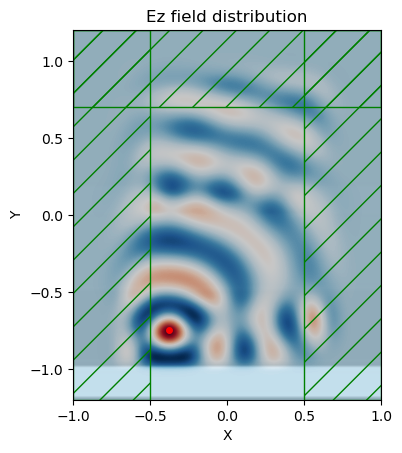

FloatProgress(value=0.0, description='0% done ', max=200.0)

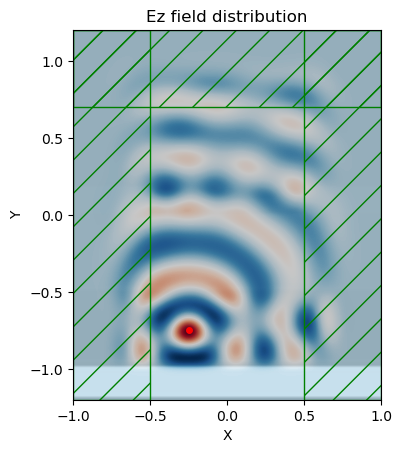

FloatProgress(value=0.0, description='0% done ', max=200.0)

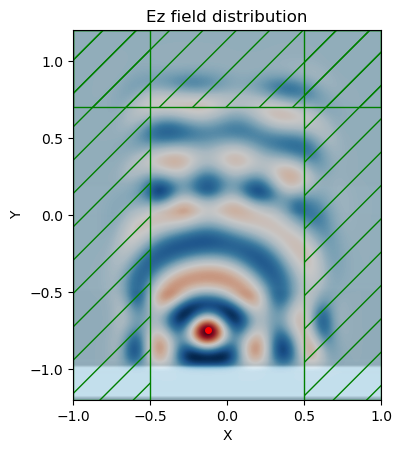

FloatProgress(value=0.0, description='0% done ', max=200.0)

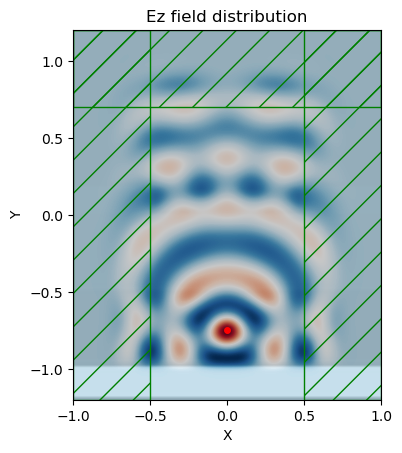

FloatProgress(value=0.0, description='0% done ', max=200.0)

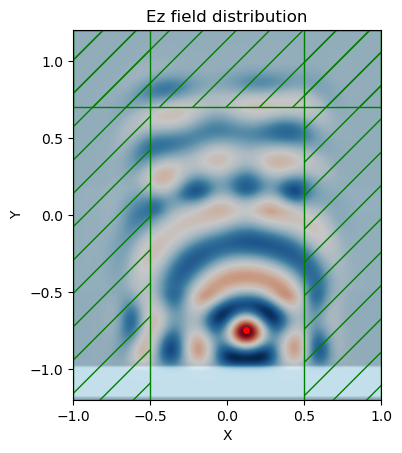

FloatProgress(value=0.0, description='0% done ', max=200.0)

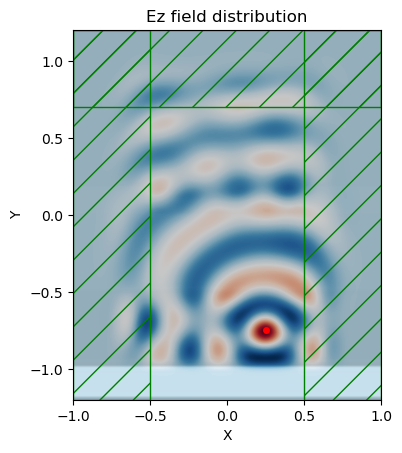

FloatProgress(value=0.0, description='0% done ', max=200.0)

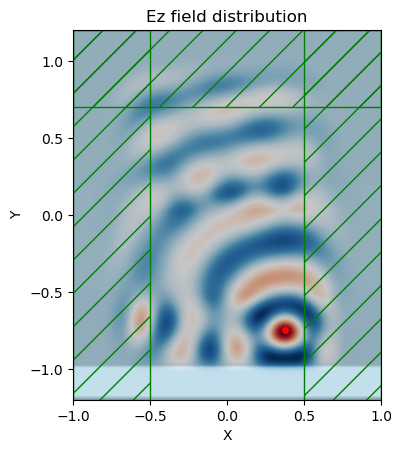

In [13]:
src = mp.ContinuousSource(frequency=fcen, fwidth=df, is_integrated=True)
source = []
src_num = 7

for i in range(src_num):  # x 방향 루프
        source.append(
            mp.Source(
                src,
                component=mp.Ez,
                center=mp.Vector3(
                    x = -design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),  
                    y = 0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG,
                    z = 0
                )
            )
        )
ppopt =[]
for i in range(src_num):
    ppopt.append(
        mp.Simulation(resolution=resolution,
                      cell_size=cell_size,
                      boundary_layers=boundary_layers,
                      geometry=geometry,
                      sources=[source[i]],
                      extra_materials=[ALU],)
    )

for i in range(src_num):
    ppopt[i].run(until=200)
    ppopt[i].plot2D(fields=mp.Ez) #, plot_sources_flag=False, plot_boundaries_flag=False, plot_monitors_flag=False)
    plt.title("Ez field distribution")
    plt.show()

In [14]:
flux_srcbox_top =[0]*src_num
flux_srcbox_bot =[0]*src_num
flux_srcbox_left =[0]*src_num
flux_srcbox_right =[0]*src_num

flux_glass =[0]*src_num
flux_wvgbox_right =[0]*src_num
flux_wvgbox_left =[0]*src_num

flux_total_srcbox =[0]*src_num
flux_total_glass =[0]*src_num
flux_waveguide =[0]*src_num

FloatProgress(value=0.0, description='0% done ')

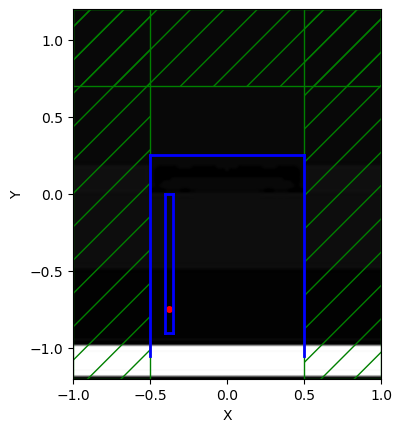

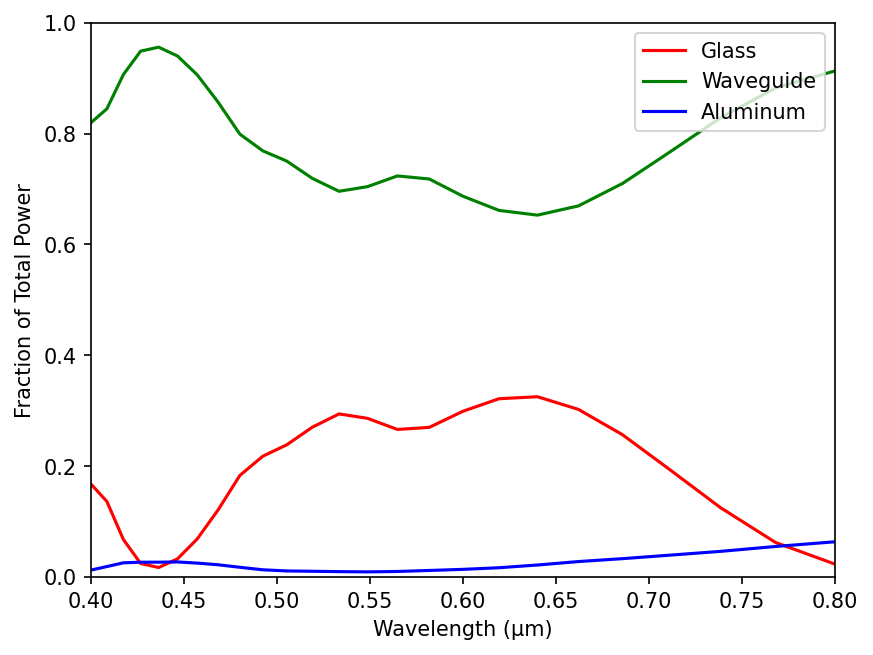

FloatProgress(value=0.0, description='0% done ')

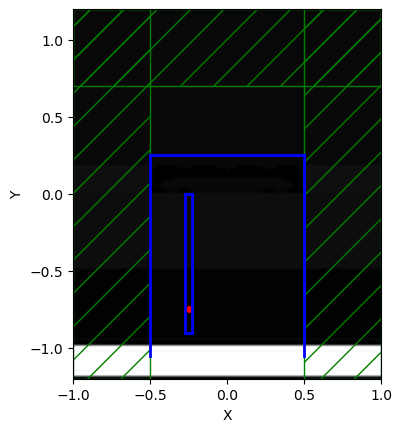

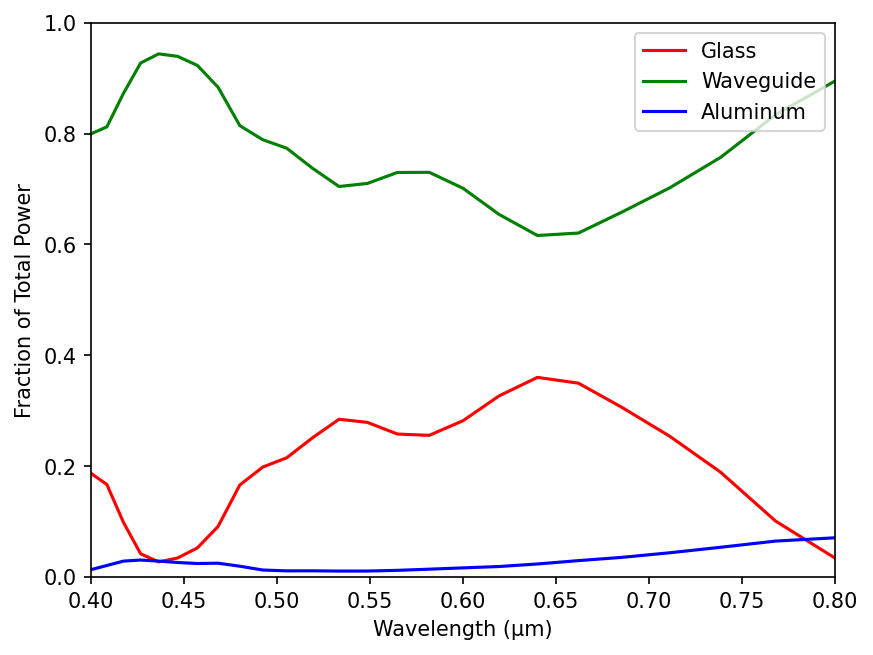

FloatProgress(value=0.0, description='0% done ')

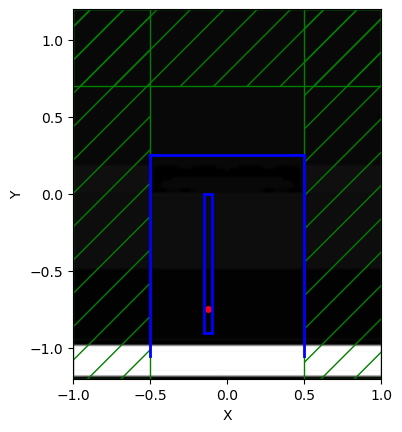

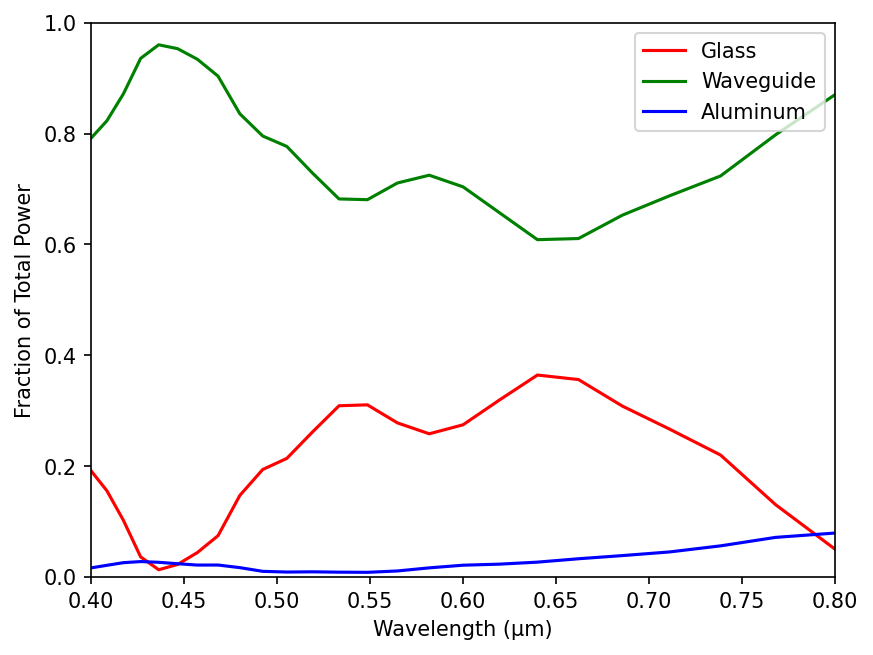

FloatProgress(value=0.0, description='0% done ')

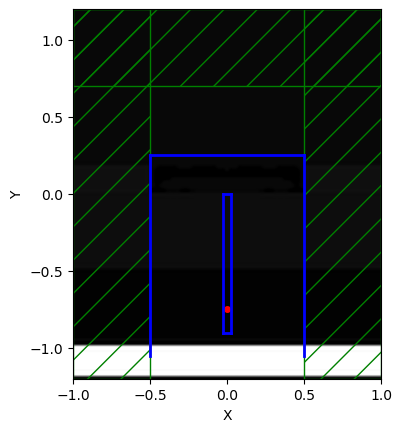

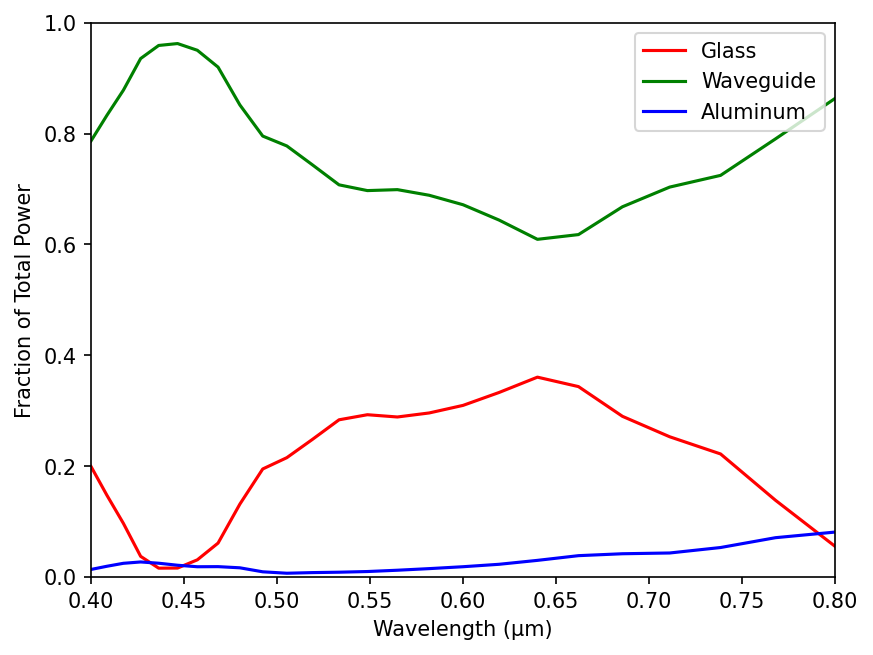

FloatProgress(value=0.0, description='0% done ')

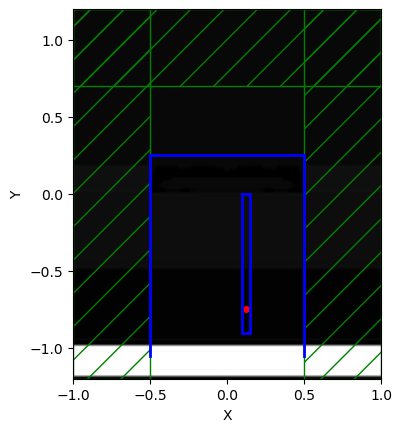

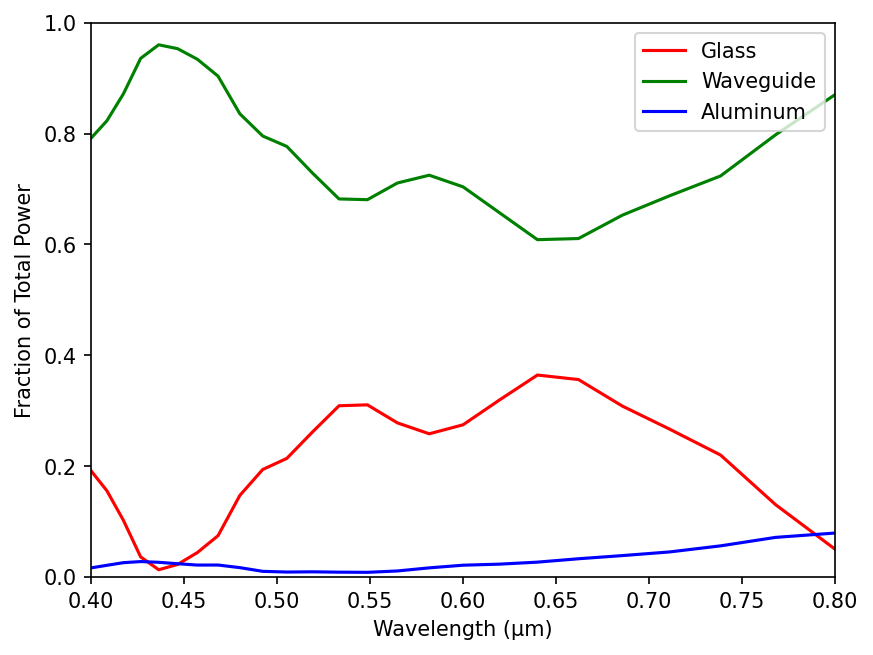

FloatProgress(value=0.0, description='0% done ')

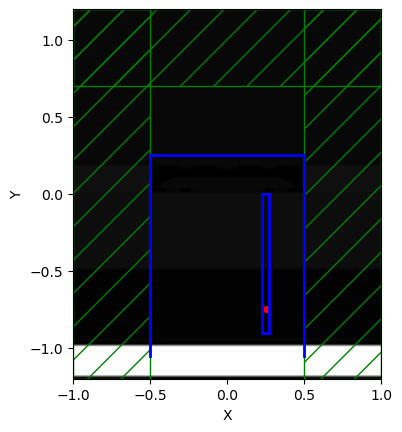

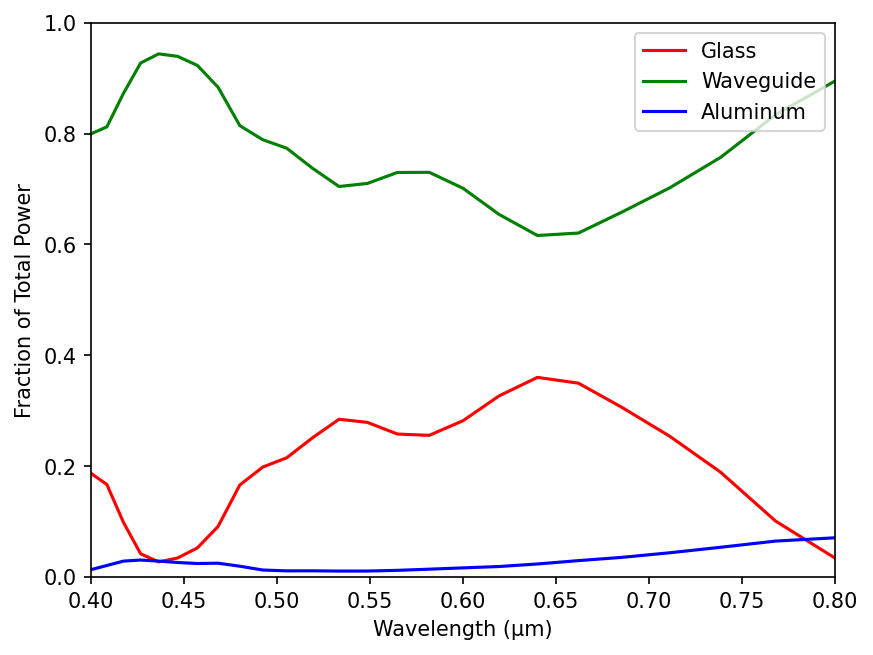

FloatProgress(value=0.0, description='0% done ')

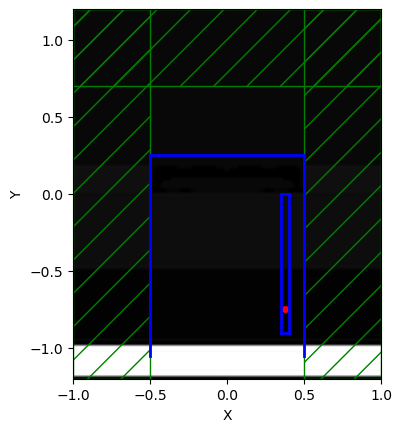

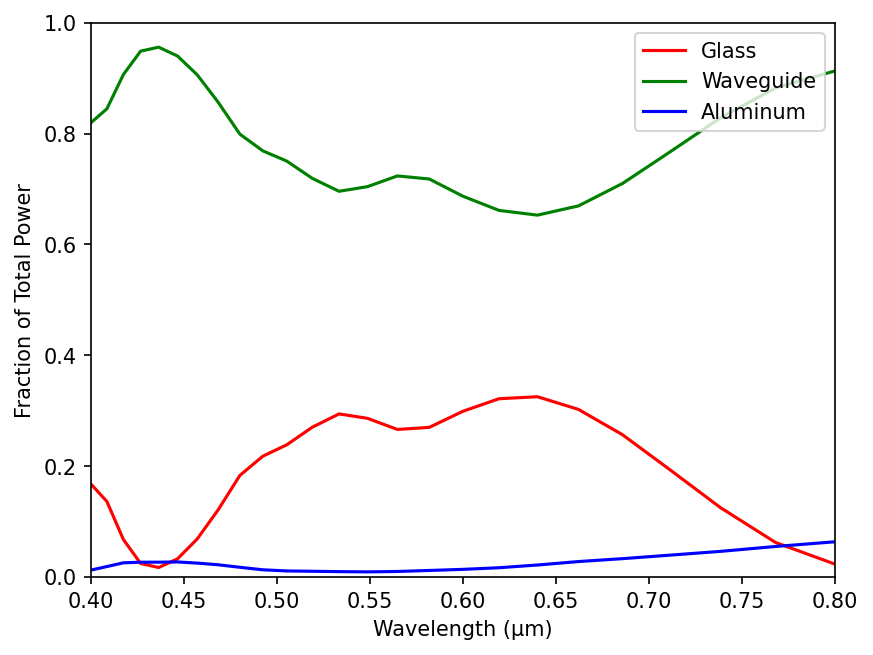

In [15]:
for i in range(src_num):
    ppopt[i].reset_meep()

    ppopt[i].sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=boundary_layers,
                        geometry=geometry,
                        sources=[sources[i]],
                        extra_materials=[ALU],)
    
    srcbox_width = 0.05
    srcbox_top = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_bot = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height-tITO-0.8*tORG), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_right = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))
    srcbox_left = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))

    fluxbox_dpad = 0.05

    glass_flux = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-(tGLS-fluxbox_dpad)), size = mp.Vector3(L,0,0)))
    wvgbox_right = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))
    wvgbox_left = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(-0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))

    ppopt[i].sim.plot2D()

    ppopt[i].sim.run(until=100.0)

    flux_srcbox_top[i] = np.asarray(mp.get_fluxes(srcbox_top))
    flux_srcbox_bot[i] = np.asarray(mp.get_fluxes(srcbox_bot))
    flux_srcbox_right[i] = np.asarray(mp.get_fluxes(srcbox_right))
    flux_srcbox_left[i] = np.asarray(mp.get_fluxes(srcbox_left))

    flux_glass[i] = np.asarray(mp.get_fluxes(glass_flux))
    flux_wvgbox_right[i] = np.asarray(mp.get_fluxes(wvgbox_right))
    flux_wvgbox_left[i] = np.asarray(mp.get_fluxes(wvgbox_left))

    flux_freqs = mp.get_flux_freqs(glass_flux)

    flux_total_srcbox[i] = flux_srcbox_top[i] - flux_srcbox_bot[i] + flux_srcbox_right[i] - flux_srcbox_left[i]
    flux_total_glass[i] = flux_glass[i]
    flux_waveguide[i] = flux_wvgbox_right[i] - flux_wvgbox_left[i]

    wl = []
    gl = []
    wg = []
    al = []
    for d in range(nfreq):
        wl = np.append(wl, 1 / (flux_freqs[d]))
        gl = np.append(gl, flux_total_glass[i][d] / flux_total_srcbox[i][d])
        wg = np.append(wg, flux_waveguide[i][d] / flux_total_srcbox[i][d])
        al = 1 - gl - wg


    if mp.am_master():
        plt.figure(dpi=150)
        plt.plot(wl, gl, "r", label="Glass")
        plt.plot(wl, wg, "g", label="Waveguide")
        plt.plot(wl, al, "b", label="Aluminum")

        
        plt.axis([0.40, 0.80, 0, 1])
        plt.xlabel("Wavelength (μm)")
        plt.ylabel("Fraction of Total Power")
        plt.legend(loc="upper right")
        plt.show()
        plt.cla()   # clear the current axes
        plt.clf()   # clear the current figure
        plt.close() # closes the current figure




In [16]:
geometryo = [
    mp.Block(material=GLS,      # 유리층
             size=mp.Vector3(mp.inf, tPML + tGLS),
             center=mp.Vector3(y=0.5*Sy - 0.5*(tPML + tGLS))),

    mp.Block(material=GLS,      # 디자인 영역
             size=mp.Vector3(mp.inf, design_region_height),
             center=design_region.center),
    
    mp.Block(material=ITO,      # ITO 층
             size=mp.Vector3(mp.inf, tITO),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - 0.5*tITO)),
    
    mp.Block(material=ORG,                       # 유기층
             size=mp.Vector3(mp.inf, tORG),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG)),
    
    mp.Block(material=ALU,                       # 알루미늄 층
             size=mp.Vector3(mp.inf, tALU),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - tORG - 0.5*tALU))
]

FloatProgress(value=0.0, description='0% done ', max=200.0)

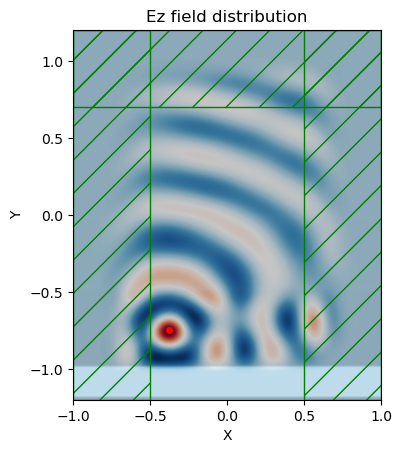

FloatProgress(value=0.0, description='0% done ', max=200.0)

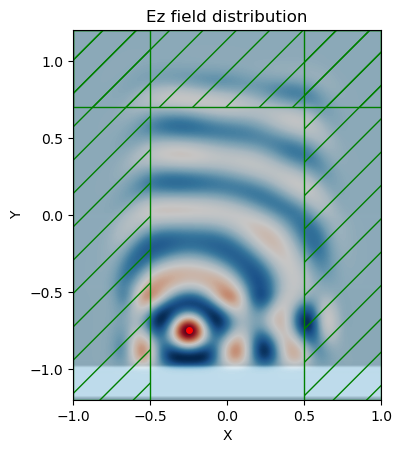

FloatProgress(value=0.0, description='0% done ', max=200.0)

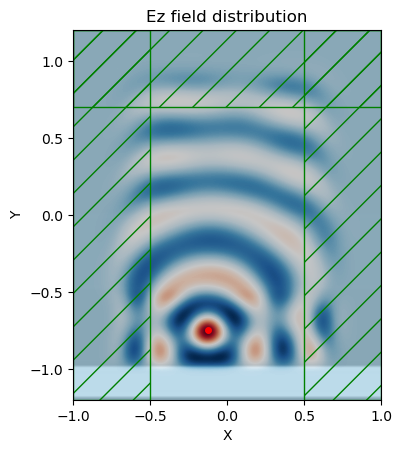

FloatProgress(value=0.0, description='0% done ', max=200.0)

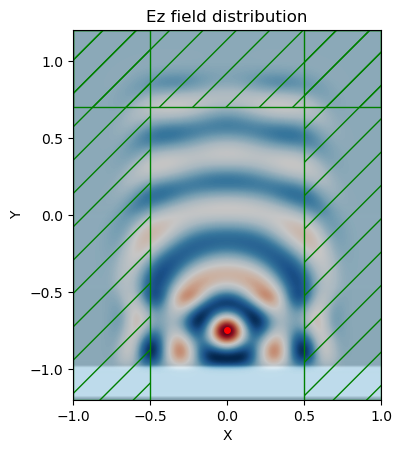

FloatProgress(value=0.0, description='0% done ', max=200.0)

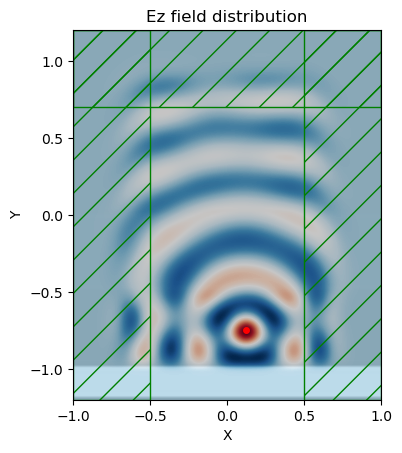

FloatProgress(value=0.0, description='0% done ', max=200.0)

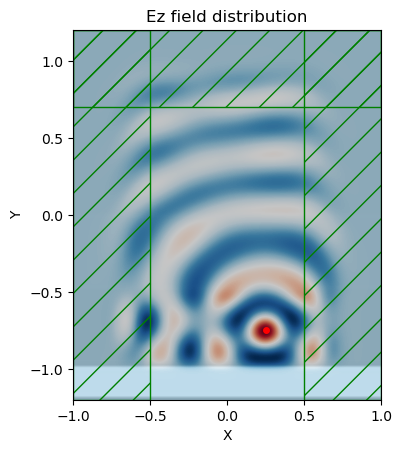

FloatProgress(value=0.0, description='0% done ', max=200.0)

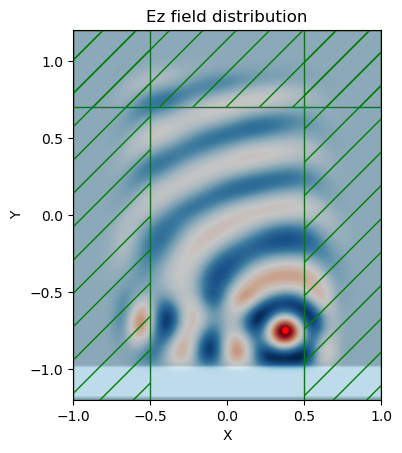

In [17]:
ppopto =[]
for i in range(src_num):
    ppopto.append(
        mp.Simulation(resolution=resolution,
                      cell_size=cell_size,
                      boundary_layers=boundary_layers,
                      geometry=geometryo,
                      sources=[source[i]],
                      extra_materials=[ALU],)
    )

for i in range(src_num):
    ppopto[i].run(until=200)
    ppopto[i].plot2D(fields=mp.Ez) #, plot_sources_flag=False, plot_boundaries_flag=False, plot_monitors_flag=False)
    plt.title("Ez field distribution")
    plt.show()

In [18]:
flux_srcbox_topo =[0]*src_num
flux_srcbox_boto =[0]*src_num
flux_srcbox_lefto =[0]*src_num
flux_srcbox_righto =[0]*src_num

flux_glasso =[0]*src_num
flux_wvgbox_righto =[0]*src_num
flux_wvgbox_lefto =[0]*src_num

flux_total_srcboxo =[0]*src_num
flux_total_glasso =[0]*src_num
flux_waveguideo =[0]*src_num

FloatProgress(value=0.0, description='0% done ')

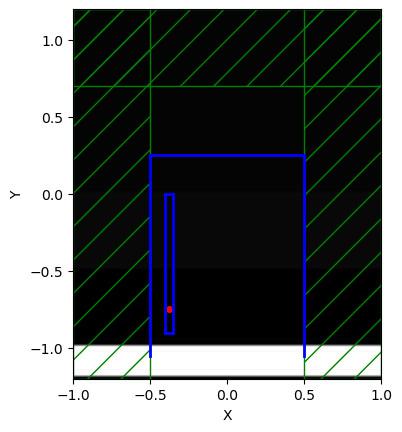

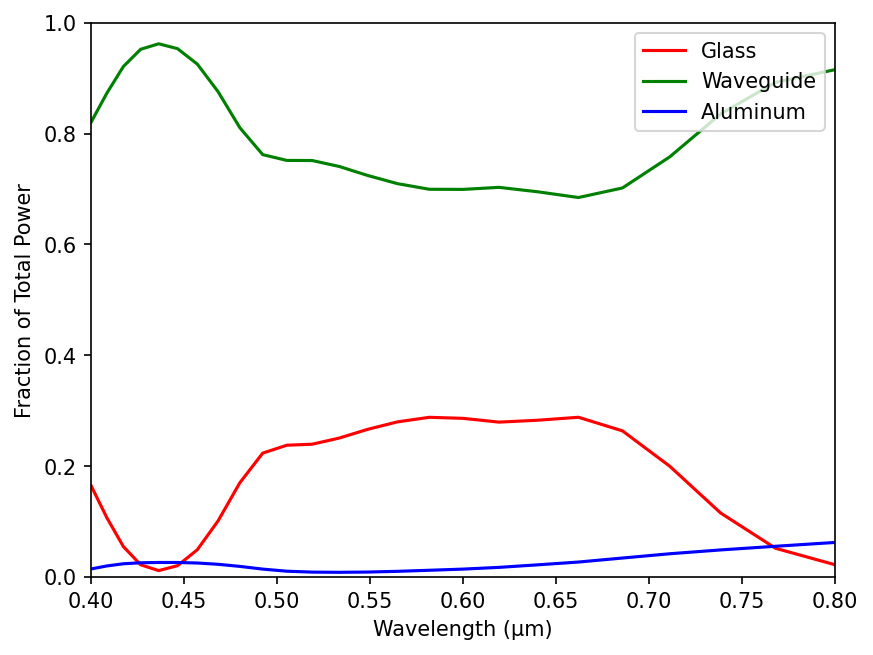

FloatProgress(value=0.0, description='0% done ')

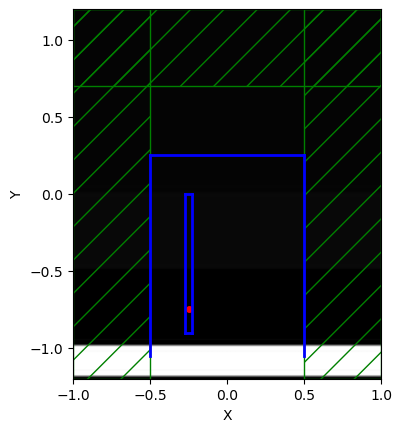

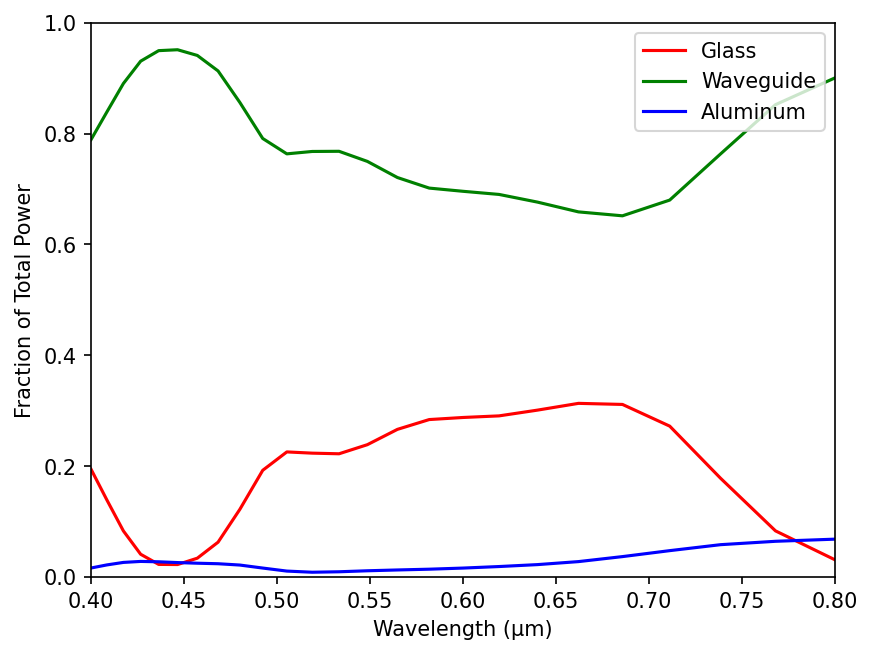

FloatProgress(value=0.0, description='0% done ')

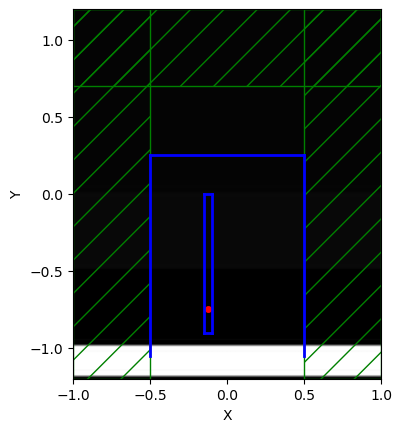

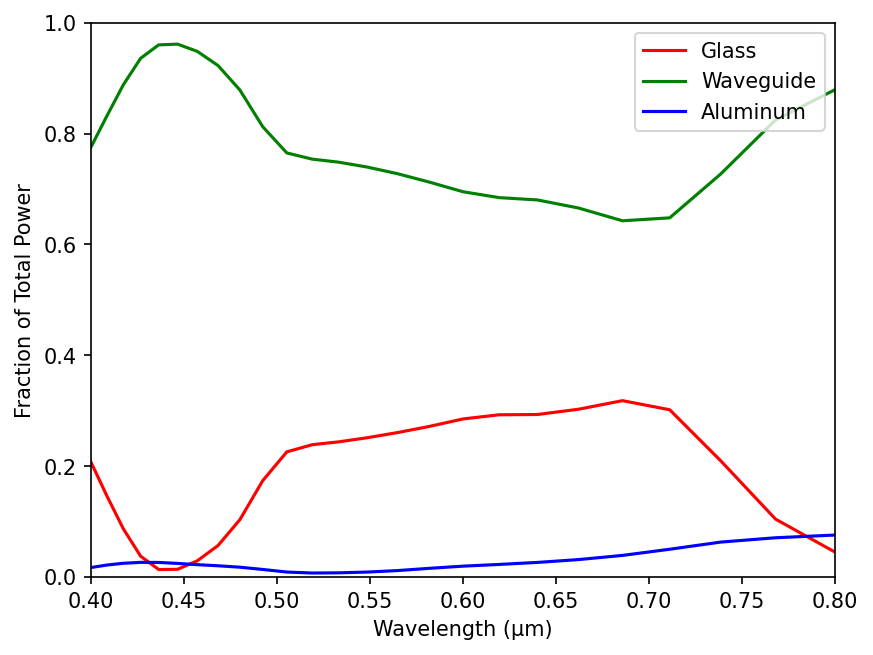

FloatProgress(value=0.0, description='0% done ')

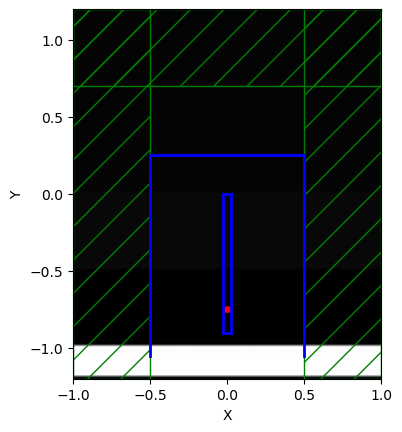

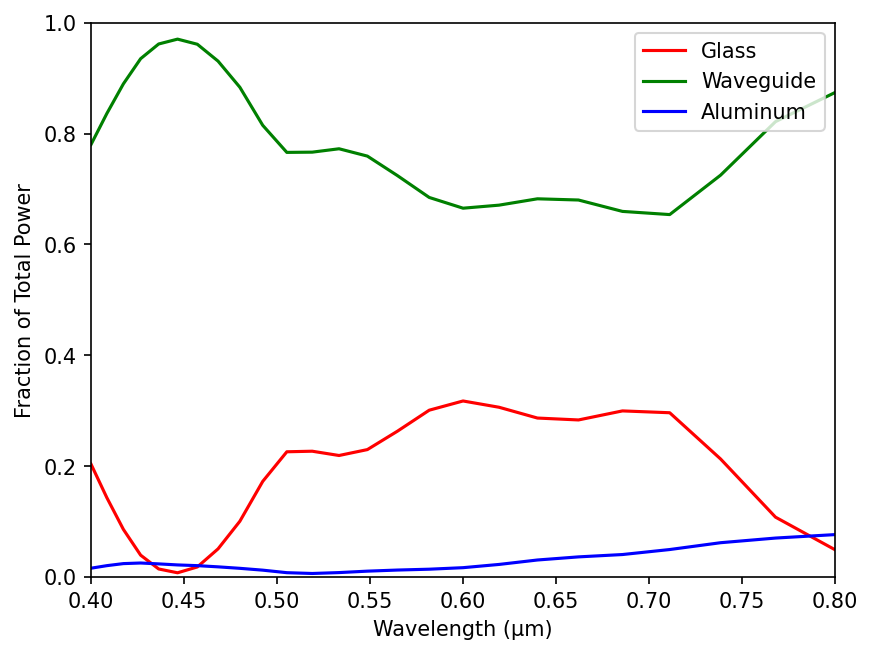

FloatProgress(value=0.0, description='0% done ')

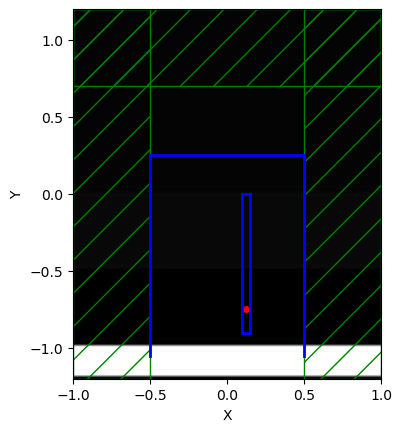

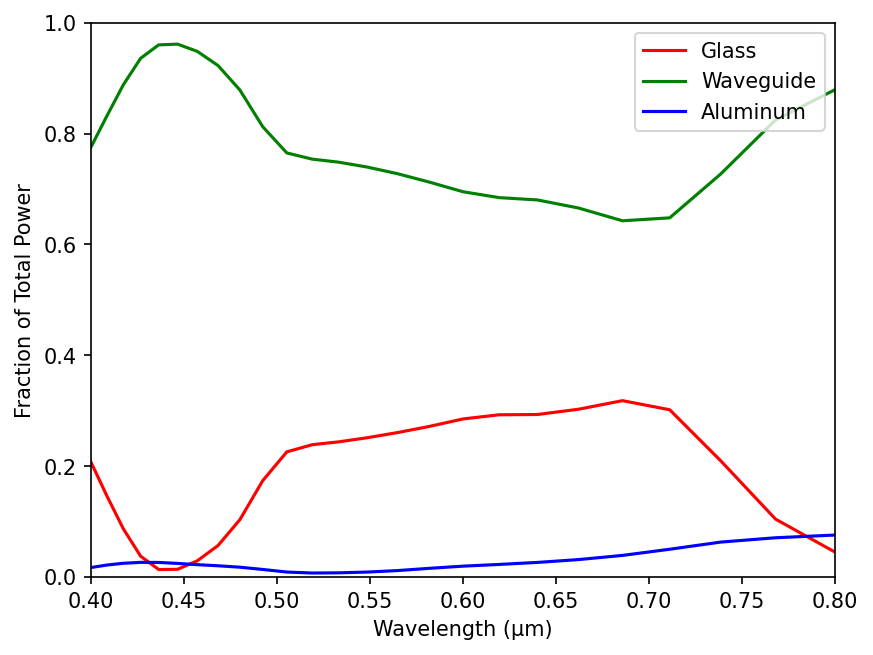

FloatProgress(value=0.0, description='0% done ')

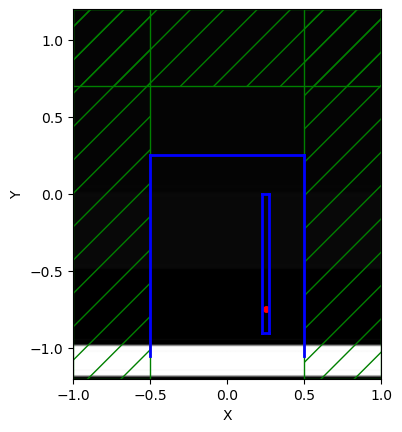

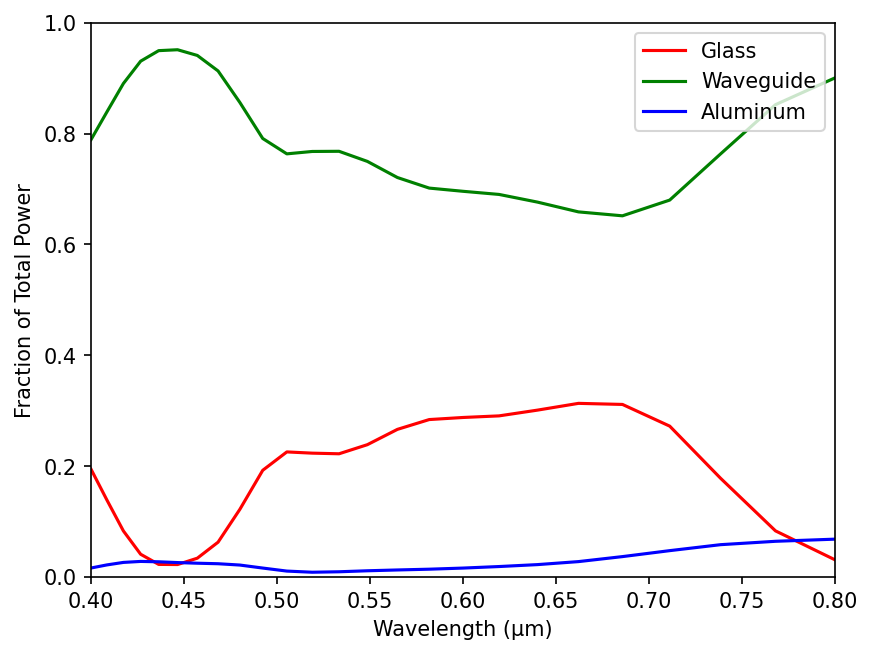

FloatProgress(value=0.0, description='0% done ')

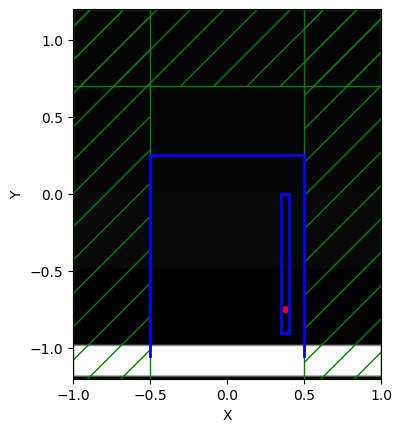

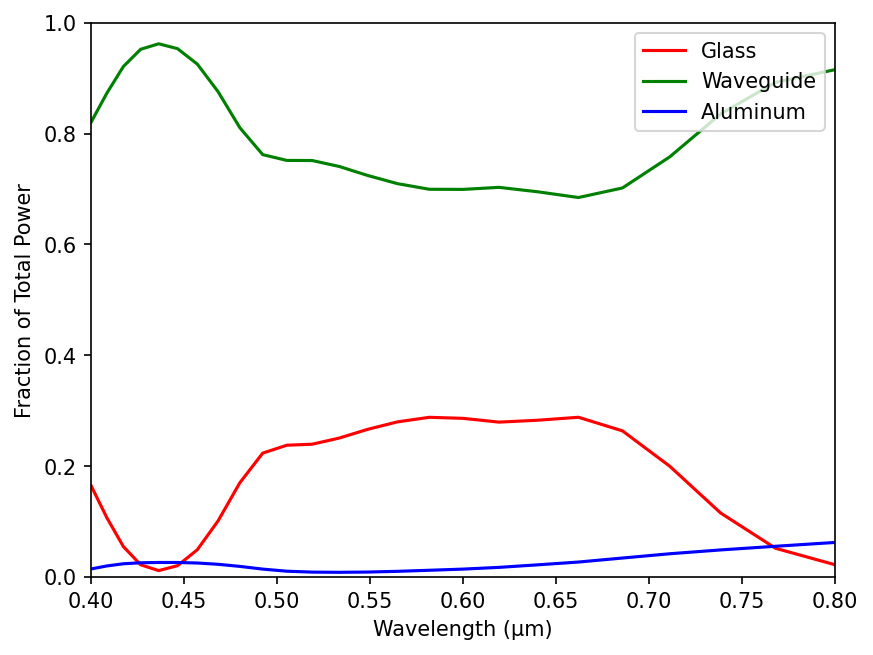

In [19]:
for i in range(src_num):
    ppopto[i].reset_meep()

    ppopto[i].sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=boundary_layers,
                        geometry=geometryo,
                        sources=[sources[i]],
                        extra_materials=[ALU],)
    
    srcbox_width = 0.05
    srcbox_top = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_bot = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height-tITO-0.8*tORG), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_right = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))
    srcbox_left = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))

    fluxbox_dpad = 0.05

    glass_flux = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-(tGLS-fluxbox_dpad)), size = mp.Vector3(L,0,0)))
    wvgbox_right = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))
    wvgbox_left = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(-0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))

    ppopto[i].sim.plot2D()

    ppopto[i].sim.run(until=100.0)

    flux_srcbox_topo[i] = np.asarray(mp.get_fluxes(srcbox_top))
    flux_srcbox_boto[i] = np.asarray(mp.get_fluxes(srcbox_bot))
    flux_srcbox_righto[i] = np.asarray(mp.get_fluxes(srcbox_right))
    flux_srcbox_lefto[i] = np.asarray(mp.get_fluxes(srcbox_left))

    flux_glasso[i] = np.asarray(mp.get_fluxes(glass_flux))
    flux_wvgbox_righto[i] = np.asarray(mp.get_fluxes(wvgbox_right))
    flux_wvgbox_lefto[i] = np.asarray(mp.get_fluxes(wvgbox_left))

    flux_freqs = mp.get_flux_freqs(glass_flux)

    flux_total_srcboxo[i] = flux_srcbox_topo[i] - flux_srcbox_boto[i] + flux_srcbox_righto[i] - flux_srcbox_lefto[i]
    flux_total_glasso[i] = flux_glasso[i]
    flux_waveguideo[i] = flux_wvgbox_righto[i] - flux_wvgbox_lefto[i]

    wl = []
    gl = []
    wg = []
    al = []
    for d in range(nfreq):
        wl = np.append(wl, 1 / (flux_freqs[d]))
        gl = np.append(gl, flux_total_glasso[i][d] / flux_total_srcboxo[i][d])
        wg = np.append(wg, flux_waveguideo[i][d] / flux_total_srcboxo[i][d])
        al = 1 - gl - wg


    if mp.am_master():
        plt.figure(dpi=150)
        plt.plot(wl, gl, "r", label="Glass")
        plt.plot(wl, wg, "g", label="Waveguide")
        plt.plot(wl, al, "b", label="Aluminum")

        
        plt.axis([0.40, 0.80, 0, 1])
        plt.xlabel("Wavelength (μm)")
        plt.ylabel("Fraction of Total Power")
        plt.legend(loc="upper right")
        plt.show()
        plt.cla()   # clear the current axes
        plt.clf()   # clear the current figure
        plt.close() # closes the current figure

In [20]:
flux_srcbox_top_s =[0]*src_num
flux_srcbox_bot_s =[0]*src_num
flux_srcbox_left_s =[0]*src_num
flux_srcbox_right_s =[0]*src_num

flux_glass_s =[0]*src_num
flux_wvgbox_right_s =[0]*src_num
flux_wvgbox_left_s =[0]*src_num

flux_total_srcbox_s =[0]*src_num
flux_total_glass_s =[0]*src_num
flux_waveguide_s =[0]*src_num

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

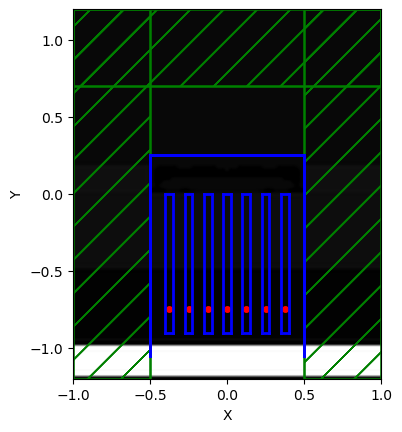

In [21]:
for i in range(src_num):
    ppopt[i].reset_meep()

    ppopt[i].sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=boundary_layers,
                        geometry=geometry,
                        sources=[sources[i]],
                        extra_materials=[ALU],)
    
    srcbox_width = 0.05
    srcbox_top = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_bot = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height-tITO-0.8*tORG), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_right = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))
    srcbox_left = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))

    fluxbox_dpad = 0.05

    glass_flux = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-(tGLS-fluxbox_dpad)), size = mp.Vector3(L,0,0)))
    wvgbox_right = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))
    wvgbox_left = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(-0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))

    ppopt[i].sim.plot2D()

    ppopt[i].sim.run(until=100.0)

    flux_srcbox_top_s[i] = np.asarray(mp.get_fluxes(srcbox_top))
    flux_srcbox_bot_s[i] = np.asarray(mp.get_fluxes(srcbox_bot))
    flux_srcbox_right_s[i] = np.asarray(mp.get_fluxes(srcbox_right))
    flux_srcbox_left_s[i] = np.asarray(mp.get_fluxes(srcbox_left))

    flux_glass_s[i] = np.asarray(mp.get_fluxes(glass_flux))
    flux_wvgbox_right_s[i] = np.asarray(mp.get_fluxes(wvgbox_right))
    flux_wvgbox_left_s[i] = np.asarray(mp.get_fluxes(wvgbox_left))

    flux_freqs = mp.get_flux_freqs(glass_flux)

    flux_total_srcbox_s[i] = flux_srcbox_top_s[i] - flux_srcbox_bot_s[i] + flux_srcbox_right_s[i] - flux_srcbox_left_s[i]
    flux_total_glass_s[i] = flux_glass_s[i]
    flux_waveguide_s[i] = flux_wvgbox_right_s[i] - flux_wvgbox_left_s[i]



In [22]:
flux_srcbox_topo_s =[0]*src_num
flux_srcbox_boto_s =[0]*src_num
flux_srcbox_lefto_s =[0]*src_num
flux_srcbox_righto_s =[0]*src_num

flux_glasso_s =[0]*src_num
flux_wvgbox_righto_s =[0]*src_num
flux_wvgbox_lefto_s =[0]*src_num

flux_total_srcboxo_s =[0]*src_num
flux_total_glasso_s =[0]*src_num
flux_waveguideo_s =[0]*src_num

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

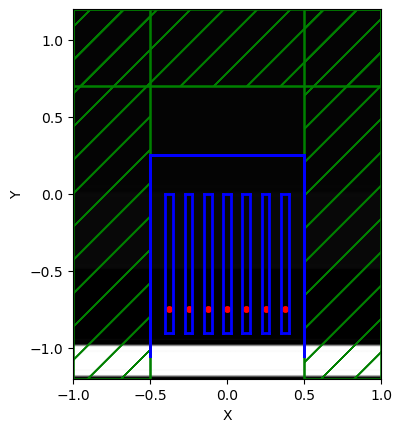

In [23]:
for i in range(src_num):
    ppopto[i].reset_meep()

    ppopto[i].sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=boundary_layers,
                        geometry=geometryo,
                        sources=[sources[i]],
                        extra_materials=[ALU],)
    
    srcbox_width = 0.05
    srcbox_top = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_bot = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height-tITO-0.8*tORG), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_right = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))
    srcbox_left = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))

    fluxbox_dpad = 0.05

    glass_flux = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-(tGLS-fluxbox_dpad)), size = mp.Vector3(L,0,0)))
    wvgbox_right = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))
    wvgbox_left = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(-0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))

    ppopto[i].sim.plot2D()

    ppopto[i].sim.run(until=100.0)

    flux_srcbox_topo_s[i] = np.asarray(mp.get_fluxes(srcbox_top))
    flux_srcbox_boto_s[i] = np.asarray(mp.get_fluxes(srcbox_bot))
    flux_srcbox_righto_s[i] = np.asarray(mp.get_fluxes(srcbox_right))
    flux_srcbox_lefto_s[i] = np.asarray(mp.get_fluxes(srcbox_left))

    flux_glasso_s[i] = np.asarray(mp.get_fluxes(glass_flux))
    flux_wvgbox_righto_s[i] = np.asarray(mp.get_fluxes(wvgbox_right))
    flux_wvgbox_lefto_s[i] = np.asarray(mp.get_fluxes(wvgbox_left))

    flux_freqs = mp.get_flux_freqs(glass_flux)

    flux_total_srcboxo_s[i] = flux_srcbox_topo_s[i] - flux_srcbox_boto_s[i] + flux_srcbox_righto_s[i] - flux_srcbox_lefto_s[i]
    flux_total_glasso_s[i] = flux_glasso_s[i]
    flux_waveguideo_s[i] = flux_wvgbox_righto_s[i] - flux_wvgbox_lefto_s[i]


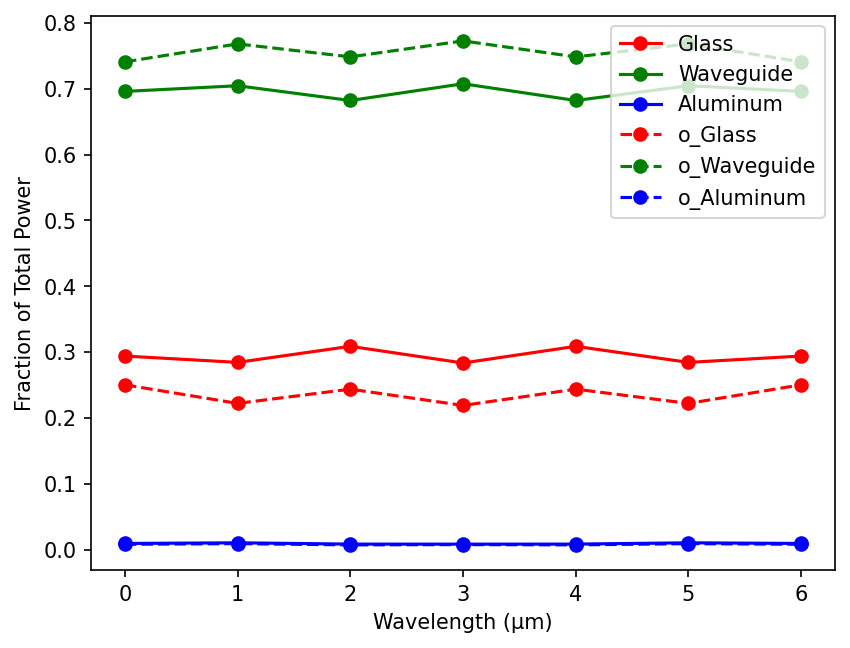

In [24]:
wl = []
gl = []
wg = []
al = []
o_gl = []
o_wg = []
o_al = []
for d in range(src_num):
    wl = np.append(wl, d)
    gl = np.append(gl, flux_total_glass_s[d] / flux_total_srcbox_s[d])
    wg = np.append(wg, flux_waveguide_s[d] / flux_total_srcbox_s[d])
    al = 1 - gl - wg
    o_gl = np.append(o_gl, flux_total_glasso_s[d] / flux_total_srcboxo_s[d])
    o_wg = np.append(o_wg, flux_waveguideo_s[d] / flux_total_srcboxo_s[d])
    o_al = 1 - o_gl - o_wg


if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, gl, "r-o", label="Glass")
    plt.plot(wl, wg, "g-o", label="Waveguide")
    plt.plot(wl, al, "b-o", label="Aluminum")
    plt.plot(wl, o_gl, "r--o", label="o_Glass")
    plt.plot(wl, o_wg, "g--o", label="o_Waveguide")
    plt.plot(wl, o_al, "b--o", label="o_Aluminum")

    
    # plt.axis([0.40, 0.80, 0, 1])
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("Fraction of Total Power")
    plt.legend(loc="upper right")
    plt.show()
    plt.cla()   # clear the current axes
    plt.clf()   # clear the current figure
    plt.close() # closes the current figure

In [25]:
print(flux_total_glass_s)

[array([0.15980715]), array([0.15829371]), array([0.1629771]), array([0.15915374]), array([0.1629771]), array([0.15829371]), array([0.15980715])]


In [26]:
print(flux_total_glasso_s)

[array([0.12674636]), array([0.11485976]), array([0.11993062]), array([0.11746403]), array([0.11993062]), array([0.11485976]), array([0.12674636])]
